# Data

The data contains parsed scrapes of a Russian cryptomarket called Hydra. Hydra is a person-to-person illegal drug marketplace on the "Dark Web" (accessible via TOR browser). The basic layout resembles eBay or any other online marketplace.

The scrape (mirror of the website) was conducted by myself in 2017 for another project.
The parsed datafiles used in this notebook contain:
<br>
<br>
1) Item pages - pages of **12,378 drug items** on the marketplace, each containing: ID, name, description, seller, shipping locations of each item.
<br>
2) Buyer profiles - profile pages of **101,965 buyer profiles**, each containing nickname, number of transactions and date of registration.
<br>
3) Feedback messages - **574,274 buyer feedback messages** left for each item/seller after a transaction. It contains buyer nickname (author of message), seller nickname (from whom the author bought an item), item ID, date of message, buyer's location
<br>
4) (omitted in this notebook) Price of items - Prices for different weights of (most) items. 
<br>
![test](screenshot.png)


# 1. Setup

### Packages

In [866]:
### Main packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from datetime import datetime
import time

# Set locale to recognize Cyrillic symbols
import locale
locale.setlocale(locale.LC_TIME, 'ru_RU.UTF-8')

# Import transliterate package to convert Cyrillic -> Latin
from transliterate import translit

# Evaluate tuples from strings
from ast import literal_eval

# Import geocoder from geopy
from geopy.geocoders import Nominatim

# Plotly for geoplot
import plotly.plotly as py
import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='LNorbutas', api_key='OWp4O3z5v1ZaNs3O6cHa')

# Ignore warnings 
import warnings
warnings.filterwarnings('ignore')

### Read data

\*\*\*Description of data here\*\*\*

In [1016]:
# Transactions (buyer feedback dataset)
data_feedback = pd.read_csv('feedback.csv')

# Item data
data_items = pd.read_csv('items.csv')

# Buyer profile data
data_buyers = pd.read_csv('buyer.csv')

### Data cleaning

The data is pretty messy and requires a lot of prep-work. This section is mostly cleaning up/transliteration.

#### Feedback data

In [868]:
print("Some columns contain data in Cyrilic. That is the case for all datasets: ")
data_feedback.head()

Some columns contain data in Cyrilic. That is the case for all datasets: 


,buyer,seller,item_id,rating,text,date,buyer_location,filename
0,william,Henry_Kissinger,999,Оценка: 10,клад найден)),18 Августа в 22:24,Москва,999/profile/9946@page=9
1,Dvorkin12,Henry_Kissinger,999,Оценка: 10,"Магазин отличный рекомендую.\r\nСтаф 4+, за та...",18 Августа в 18:48,Москва,999/profile/9946@page=9
2,Ksvsj,Henry_Kissinger,999,Оценка: 10,"хороший магазин, еще вернусь!)",18 Августа в 18:45,Москва,999/profile/9946@page=9
3,hombo21,Henry_Kissinger,999,Оценка: 10,"Всё ок, поднял в одно косание, только не сразу...",18 Августа в 07:53,Москва,999/profile/9946@page=9
4,Ksvsj,Henry_Kissinger,999,Оценка: 10,"Все ок, вот только стафчик слабоват! А так все...",18 Августа в 01:06,Москва,999/profile/9946@page=9


In [869]:
## Keep relevant columns
data_feedback = data_feedback[["buyer", "seller", "item_id", "rating", "date", "buyer_location"]]

In [870]:
## Missing data
print(data_feedback.isna().sum())   # 1,624 cases in buyer_location

# Encode missing to empty strings (to avoid transliteration type error and retain other data)
data_feedback.loc[data_feedback.buyer_location.isna(), "buyer_location"] = ""

buyer                0
seller               0
item_id              0
rating               0
date                 0
buyer_location    1624
dtype: int64


In [871]:
## Transliterate cyrillic columns (nicknames and locations)
# *** Takes about a minute to run! ***
print(f"Example of transliteration: {data_feedback.buyer_location[0]}", 
      f"{translit(data_feedback.buyer_location[0], 'ru', reversed=True)}")

data_feedback[["buyer", "seller", "buyer_location"]] = (data_feedback[["buyer", "seller", "buyer_location"]]
                                                        .applymap(lambda x: 
                                                                  translit(x, "ru", reversed=True, strict=True)))

Example of transliteration: Москва Moskva


In [872]:
## Remove string leftovers from "rating" column
data_feedback.rating = data_feedback.rating.str.replace("Оценка: ", "")

In [873]:
## Parse Cyrillic dates

# Dates contain "today" and "yesterday"
print(f"Before replacement: \n{data_feedback.date.iloc[[0, -10, -9]]}")

# Dates from 2017 do not have the year in the string, while earlier years have them
print(data_feedback.date[[1,193000]], "\n\n")

# Harmonize dates: 1) Add 2017 to all dates that contain no year
#                  2) Remove " в " from all strings to enable parsing to datetime
#                  3) Replace "today" to 2017-11-05 (date of data collection), "yesterday" - 2017-11-04

dict1 = {'а в ': 'а 2017 ',
         'я в ': 'я 2017 ',
         'сегодня': '05 ноября',
         'вчера': '04 ноября',
         ' в ': ' '}
data_feedback.date = data_feedback.date.str.strip().replace(dict1, regex=True)

print(f"After replacement: \n{data_feedback.date.iloc[[0, -10, -9, 1, 193000]]}")

# Parse string dates to datetime
data_feedback.date = data_feedback.date.apply(lambda x: datetime.strptime(x, '%d %B %Y %H:%M').date())

print(f"\nAfter parsing: \n{data_feedback.date.iloc[[0, -10, -9, 1, 193000]]}")

Before replacement: 
0         18 Августа в 22:24
574264       сегодня в 14:40
574265         вчера в 17:21
Name: date, dtype: object
1              18 Августа в 18:48
193000    25 Декабря 2016 в 01:20
Name: date, dtype: object 


After replacement: 
0         18 Августа 2017 22:24
574264     05 ноября 2017 14:40
574265     04 ноября 2017 17:21
1         18 Августа 2017 18:48
193000    25 Декабря 2016 01:20
Name: date, dtype: object

After parsing: 
0         2017-08-18
574264    2017-11-05
574265    2017-11-04
1         2017-08-18
193000    2016-12-25
Name: date, dtype: object


#### Item data

In [1017]:
data_items.head()

,name,description,instock,shipsfrom,seller,filename
0,"ГЕРОИН ОТ ПАТРИАРХА [100,0] | HYDRA",NaN,1,Москва ...,ГЕРОИН ОТ ПАТРИАРХА,9997.0
1,"ГЕРОИН ОТ ПАТРИАРХА [50,0] | HYDRA",NaN,1,Москва ...,ГЕРОИН ОТ ПАТРИАРХА,9996.0
2,ГЕРОИН ОТ ПАТРИАРХА [Октябрь] | HYDRA,"Партия ОКТЯБРЯ 17-го!Разовая дозировка 0,05-0,...",1,Москва ...,ГЕРОИН ОТ ПАТРИАРХА,9994.0
3,МЕТАДОН ОТ ПАТРИАРХА | HYDRA,Дефицитный продукт. Ограниченная партия.График...,1,Москва ...,ГЕРОИН ОТ ПАТРИАРХА,9993.0
4,"Амфетамин ""Айсберг"" | HYDRA","Именно об этом подумал Стаффмен, впервые попро...",1,МоскваБрянскСаратовЕкатеринбург ...,The Stuff-man,9990.0


In [1021]:
## Select relevant columns
data_items = data_items[["name", "seller", "filename"]]

In [1022]:
## Transliterate Cyrillic chars
data_items[["name", "seller"]] = data_items[["name", "seller"]].applymap(lambda x: translit(x, "ru", reversed=True))

In [1023]:
data_items.head()

,name,seller,filename
0,"GEROIN OT PATRIARHA [100,0] | HYDRA",GEROIN OT PATRIARHA,9997.0
1,"GEROIN OT PATRIARHA [50,0] | HYDRA",GEROIN OT PATRIARHA,9996.0
2,GEROIN OT PATRIARHA [Oktjabr'] | HYDRA,GEROIN OT PATRIARHA,9994.0
3,METADON OT PATRIARHA | HYDRA,GEROIN OT PATRIARHA,9993.0
4,"Amfetamin ""Ajsberg"" | HYDRA",The Stuff-man,9990.0


#### Buyers data

In [878]:
data_buyers.head()

,nickname,purchases,datereg,filename
0,bandit22812,7,29.09.2017,buyer10000
1,Танда,3,28.07.2017,buyer100001
2,ТвояБабушка,7,08.03.2017,buyer100020
3,Техноснаб,2,09.09.2017,buyer100031
4,Тирион Ланнистер,2,19.05.2017,buyer100051


In [879]:
## Keep relevant cols
data_buyers = data_buyers[["nickname", "purchases", "datereg"]]

In [880]:
## Transliterate nicknames
data_buyers["nickname"] = data_buyers["nickname"].apply(lambda x: translit(x, "ru", reversed=True))

In [881]:
## Parse dates (this time not in Cyrillic)
data_buyers.datereg = data_buyers["datereg"].apply(lambda x: datetime.strptime(x, "%d.%m.%Y").date())

In [882]:
## Purchases column has some rounding in the data above 500 purchases
strange_cases = data_buyers.loc[data_buyers["purchases"].str.contains("\+"), "purchases"].str.replace("\+", "")
data_buyers.loc[data_buyers["purchases"].str.contains("\+"), "purchases"] = strange_cases

In [883]:
data_buyers.head()

,nickname,purchases,datereg
0,bandit22812,7,2017-09-29
1,Tanda,3,2017-07-28
2,TvojaBabushka,7,2017-03-08
3,Tehnosnab,2,2017-09-09
4,Tirion Lannister,2,2017-05-19


# 2. Exploratory data analysis

### Users over time

Buyers' dataset contains the date of registration of the buyer accounts. For **sellers' date of registration** it is slightly more difficult, since there is **no data** on that. We roughly assume that seller's registration equals the date of first feedback message.

In [884]:
# Buyers' date of registration
buyers_date_reg = data_buyers[["nickname", "datereg"]]
buyers_date_reg["user_class"] = "buyer"

# Sellers' date of registration = date of first feedback message
sellers_date_reg = data_feedback.groupby("seller").date.min().reset_index()
sellers_date_reg["user_class"] = "seller"
sellers_date_reg.columns = ["nickname", "datereg", "user_class"]

# Users dataset merge...
users_date_reg = buyers_date_reg.append(sellers_date_reg)
# ... and aggregation (count by date and class)
users_date_reg_agg = users_date_reg.groupby(["datereg", "user_class"]).count().reset_index()
users_date_reg_agg.columns = ["datereg", "user_class", "total"]

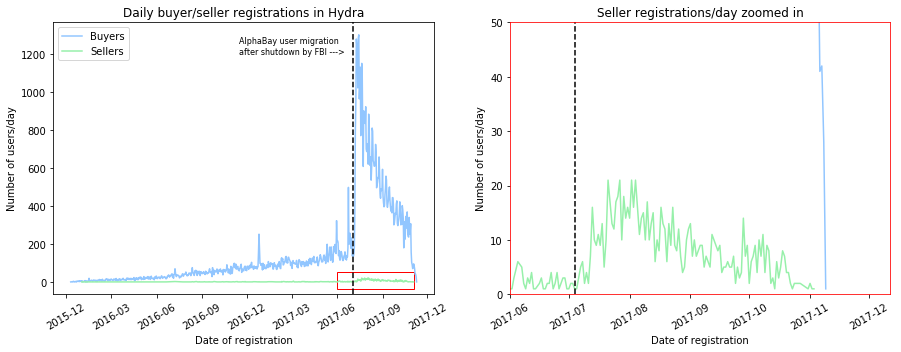

Mean # new buyers/day: 145.6642857142857       
Mean # new sellers/day: 4.063444108761329


In [885]:
## Plot
# 1. Main plot
plt.figure(figsize=(15,5))
plt.style.use("seaborn-pastel")
plt.subplot(1, 2, 1)
plot_users_date = sns.lineplot(x="datereg", y="total", hue="user_class", data=users_date_reg_agg, legend=False)
plt.xticks(rotation=30)
plt.xlabel("Date of registration")
plt.ylabel("Number of users/day")
plt.legend(title=None, loc="upper left", labels=["Buyers", "Sellers"])
plt.title("Daily buyer/seller registrations in Hydra")
square = plot_users_date.add_patch(patches.Rectangle((datetime(2017,6,1),-35),155,90,linewidth=1,edgecolor='r',facecolor='none'))
plt.axvline(x=datetime(2017,7,4), color="black", linestyle = "--")
plt.text(datetime(2016,11,15), 1200, "AlphaBay user migration\nafter shutdown by FBI --->", size=8)

# 2. Sellers subplot
plt.subplot(1, 2, 2)
plt.style.use("seaborn-pastel")
plot_sellers_date = sns.lineplot(x="datereg", y="total", hue="user_class", data=users_date_reg_agg, legend=False)
plt.xticks(rotation=30)
plt.xlabel("Date of registration")
plt.ylabel("Number of users/day")
plt.xlim(datetime(2017,6,1), datetime(2017,12,12))
plt.ylim(0,50)
plt.title("Seller registrations/day zoomed in")
plt.axvline(x=datetime(2017,7,4), color="black", linestyle = "--")
[plot_sellers_date.spines[x].set_color("red") for x in ["top", "bottom", "left", "right"]]

plt.show()
print(f'Mean # new buyers/day: {users_date_reg_agg.loc[users_date_reg_agg["user_class"] == "buyer",:].total.mean()} \
      \nMean # new sellers/day: {users_date_reg_agg.loc[users_date_reg_agg["user_class"] == "seller",:].total.mean()}')

In [886]:
# Cumulative number of users using cumsum
users_date_reg_total = users_date_reg_agg.groupby("datereg").total.sum().reset_index()
users_date_reg_total = pd.DataFrame({"datereg": users_date_reg_agg["datereg"], 
                                     "total": users_date_reg_total.total.cumsum()})

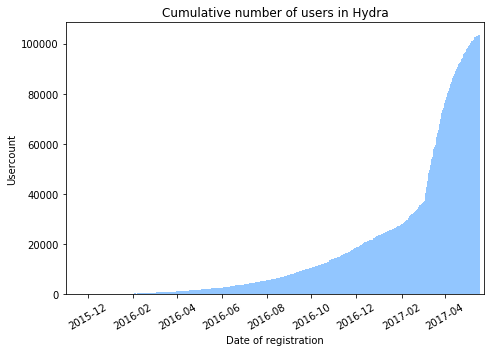

In [887]:
## Plot 
plt.figure(figsize=(7.5,5))
plt.style.use("seaborn-pastel")
plt.bar(x="datereg", height="total", width=1, data=users_date_reg_total)
plt.xticks(rotation=30)
plt.xlim(datetime(2015,11,1), datetime(2017,5,25))
plt.xlabel("Date of registration")
plt.ylabel("Usercount")
plt.title("Cumulative number of users in Hydra")

plt.show()

### Sales (sellers) and purchases (buyers) distributions

Once again, buyers have data on total purchases, while sellers do not have any data on total sales. I assume that total sales = sum of feedback messages, even though in reality a large % of transactions do not receive a feedback message.

In [888]:
## Get buyers' purchases from buyer profile data
buyers_purchases = pd.to_numeric(data_buyers["purchases"])
## Get sellers' sales by counting the number of feedback messages they receive
sellers_sales = data_feedback.groupby("seller").size().reset_index().iloc[:,1]

## Make a TOP5 seller list
top_5 = data_feedback.groupby("seller").size().sort_values()

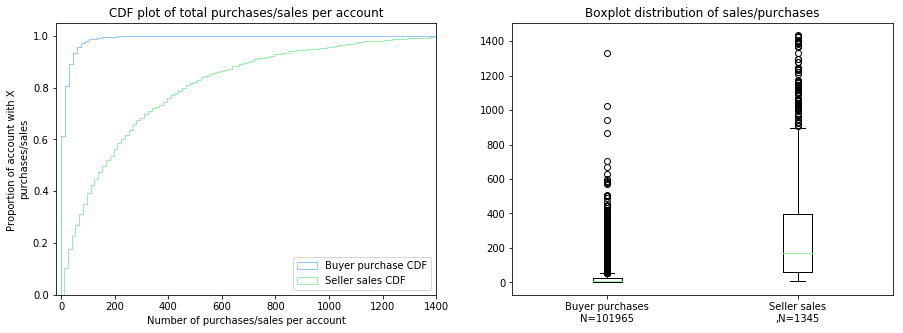

Average purchases per buyer account: 24.46      
Average sales per seller account: 426.97      

Top sellers: 
seller
Qwaysee              10456
California-Dreams     7322
NARODNYJ              5794
Manarat               5014
★LUXURY★SHOP★         5002
dtype: int64


In [889]:
## Plot
# 1. CDFs
plt.figure(figsize=(15,5))
plt.style.use("seaborn-pastel")
plt.subplot(1,2,1)
plt.hist(buyers_purchases[buyers_purchases<1700], bins=100, cumulative=True, normed=True, label='CDF',
         histtype='step')
plt.hist(sellers_sales[sellers_sales<1500], bins=100, cumulative=True, normed=True, label='CDF',
         histtype='step')
plt.xlim(-20,1400)
plt.xlabel("Number of purchases/sales per account")
plt.ylabel("Proportion of account with X \npurchases/sales")
plt.legend(["Buyer purchase CDF", "Seller sales CDF"], loc="lower right")
plt.title("CDF plot of total purchases/sales per account")

# 2. Boxplots
plt.subplot(1,2,2)
plt.boxplot([buyers_purchases[buyers_purchases<1500], sellers_sales[sellers_sales<1500]])
plt.xticks([1,2], [f"Buyer purchases\nN={len(buyers_purchases)}", f"Seller sales\n,N={len(sellers_sales)}"])
plt.title("Boxplot distribution of sales/purchases")

plt.show()
print(f"Average purchases per buyer account: {np.round(buyers_purchases.mean(),2)}\
      \nAverage sales per seller account: {np.round(sellers_sales.mean(),2)}\
      \n\nTop sellers: \n{top_5[::-1].head()}")

### Users' market activity over time

So far the purchases have only been covered aggregated for each account. We can also look for variation of purchases at each week since buyer's market entry. Since buyer's total # of purchases is aggregated in user profile data, we will use the feedback messages they leave as a proxy of their purchase activity.

In [890]:
# Get buyers' feedback messages as the proxy of purchases, convert dates
buyers_purchases_time = data_feedback[["buyer", "date"]]
buyers_purchases_time.loc[:,'date'] = pd.to_datetime(buyers_purchases_time['date'])

# Aggregate feedbacks to weekly windows for each buyer
buyers_purchases_time = buyers_purchases_time.groupby(['buyer', pd.Grouper(key='date', freq='W')])\
                                                .size().reset_index()
# Merge with buyer accounts to get date of registration
buyers_purchases_time = buyers_purchases_time.merge(data_buyers, left_on="buyer", right_on="nickname")
buyers_purchases_time = buyers_purchases_time[["buyer", "date", "datereg", 0]]
buyers_purchases_time.columns = ["buyer", "date", "datereg", "sales_per_week"]
buyers_purchases_time["datereg"] = pd.to_datetime(buyers_purchases_time["datereg"])
buyers_purchases_time["date"] = pd.to_datetime(buyers_purchases_time["date"])


# Get total purchases for each buyer
total_purchases = buyers_purchases_time.groupby("buyer").sales_per_week.sum().reset_index()
total_purchases.columns = ["buyer", "total_purchases"]
buyers_purchases_time = buyers_purchases_time.merge(total_purchases, on = "buyer")

# Count the difference between Nth week and date of registration (weeks since market entry)
buyers_purchases_time["weekno"] = (buyers_purchases_time["date"] - buyers_purchases_time["datereg"])
buyers_purchases_time["weekno"] = buyers_purchases_time.weekno.apply(lambda x: (x.days//7)+1)

# Some buyers have date of registration later than first feedback (faulty scrapes?).
# Drop these cases.
buyers_purchases_time = buyers_purchases_time.drop(
    buyers_purchases_time.loc[buyers_purchases_time["date"] < buyers_purchases_time["datereg"],:].index)

# Count proportion of purchases for each buyer made in week N
buyers_purchases_time["prc_total"] = buyers_purchases_time["sales_per_week"]/buyers_purchases_time["total_purchases"]

# For each week, count the average prc of purchases
purchases_by_week = buyers_purchases_time.groupby("weekno").prc_total.mean()

# Number of weeks each user was active for
buyers_week_active = buyers_purchases_time.groupby("buyer").weekno.max()

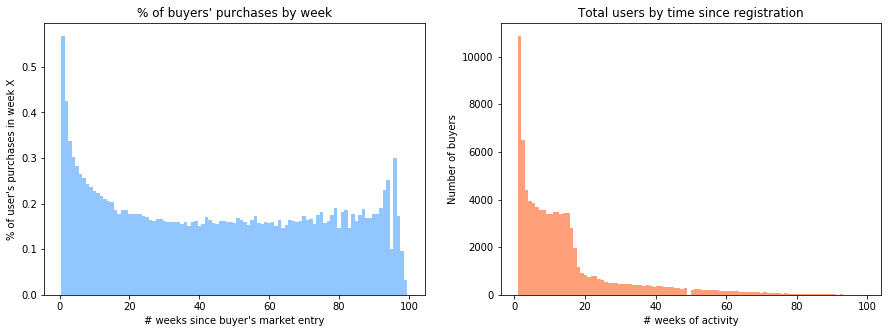

In [891]:
## Plot
# 1. Buyers activity @ week X
plt.figure(figsize=(15,5))
plt.style.use("seaborn-pastel")
plt.subplot(1,2,1)
plt.bar(x=purchases_by_week.index, height=purchases_by_week, width=1)
plt.xlabel("# weeks since buyer's market entry")
plt.ylabel("% of user's purchases in week X")
plt.title("% of buyers' purchases by week")

# 2. # weeks buyers have been active for
plt.subplot(1,2,2)
plt.hist(buyers_week_active, bins=100, color="lightsalmon")
plt.xlabel("# weeks of activity")
plt.ylabel("Number of buyers")
plt.title("Total users by time since registration")

plt.show()

### Sellers' reputation 

Sellers reputation can be calculated by averaging their ratings over all feedback messages. Most sellers have near-perfect reputation, as in most online markets. 

In [892]:
## Tab feedback rating values - 91% of ratings are 10/10
data_feedback.rating.value_counts(normalize=True, sort=True)

10    0.917073
9     0.022693
8     0.020102
7     0.012306
0     0.006859
5     0.006540
6     0.005114
1     0.003470
3     0.002527
2     0.001710
4     0.001606
Name: rating, dtype: float64

In [893]:
## Get sales and reputation data
# Sellers aggregated number of feedback messages = proxy for sales
# Usese top_5 series that were used for finding top sellers (contains all sellers) 
sellers_sales = top_5.reset_index()
sellers_sales.columns = ["seller", "sales"]

# Get feedback ratings from feedback data and calculate reputation
data_feedback["rating"] = pd.to_numeric(data_feedback["rating"])
sellers_rep = data_feedback.groupby("seller").rating.mean().reset_index()

# Merge sales and reputation
reputation_sales = sellers_rep.merge(sellers_sales, on="seller")

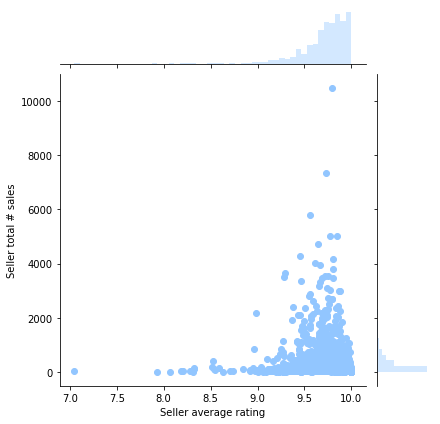

In [894]:
## Plot
plt.figure(figsize=(7.5,5))
h = sns.jointplot(x="rating", y="sales", data=reputation_sales)
h.ax_joint.set_xlabel("Seller average rating")
h.ax_joint.set_ylabel("Seller total # sales")


plt.show(plot_reputation_sales)

### Item categories

Sadly, items were not categorized in a structured way in the website at the time of data collection. I will use item names and most popular words used in them to come up with a proxy categorization for some of the items.

#### Category encoding

In [895]:
## Get item names, remove marketplace added text
item_names = data_items["name"]
item_names = item_names.str.replace(" \| HYDRA", "")

In [896]:
## Make a bag of words:
# Get every item's name, split it into words, lowercase them and store in a Series
bag_of_words = []
for x in item_names:
    words = x.split()
    for i in words:
        bag_of_words.append(i.lower())
        
bag_of_words = pd.Series(bag_of_words)

In [897]:
# Categories are selected manually - words that at least resemble drugs 
# among the most popular words
selected_categories = pd.Series(range(15), index=bag_of_words.value_counts()[[1,2,3,4,5,6,10,11,13,18,20,21,24,26,28]].index.values)

# Remapping - categories scheme for mapping categories to item names
remapping = dict(selected_categories)

# Some words refer to the same drug (e.g. cocaine and white) - recode
remapping["hash"] = 0; remapping["white"] = 5; remapping["pills"] = 6
remapping["marki"] = 12; remapping["tabletki"] = 6; remapping["cocaine"] = 5

# Reversed remapping dictionary for recoding
remapping_reversed = {v:k for k,v in remapping.items()}

In [1027]:
## Get items data and add our new categories
items = data_items.copy()
items["name_lower"] = items["name"].str.lower()
items["item_cat"] = ""

# If item name contains word in remapping scheme, store category
for k,v in remapping.items():
    items.loc[items["name_lower"].str.contains(k), "item_cat"] = v

# Make object with only those items that have a new category
data_items_cats = items.loc[items["item_cat"] != "", :]

print(f"\n\nEncoded a total of {len(data_items_cats)} items, which is \
{round(len(data_items_cats)/len(data_items),5)*100}% of all scraped items")



Encoded a total of 6028 items, which is 48.699% of all scraped items


#### Items by category and seller_diversity

Let's plot popularity of our newly coded drug categories (in terms of # items) and sellers' diversity - how many different categories of drugs each seller usually sells 

In [1028]:
## Number of items per category
# Group items by category, add counts
item_cat_counts = data_items_cats.groupby("item_cat").size().reset_index()
# Remap item category values to labels
item_cat_counts["item_cat"].replace(remapping_reversed, inplace=True)
item_cat_counts.columns = ["item_cat", "n_items"]

# Seller diversity - how many unique categories each seller sells their items in
seller_diversity = data_items_cats.groupby("seller").item_cat.nunique().reset_index()
seller_diversity.columns = ["seller", "n_categories"]

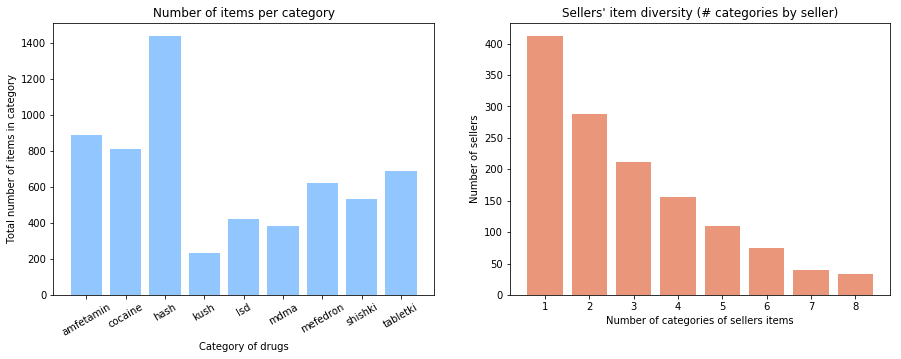

In [1029]:
## Plots
# 1. Number of items per category
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.bar(x="item_cat", height="n_items", data=item_cat_counts)
plt.xticks(rotation=30)
plt.xlabel("Category of drugs")
plt.ylabel("Total number of items in category")
plt.title("Number of items per category")

# 2. Sellers' item diversity
plt.subplot(1,2,2)
plt.hist(seller_diversity["n_categories"], bins=len(seller_diversity["n_categories"].unique())-1, align="left",
        rwidth=0.8, color="darksalmon")
plt.xlabel("Number of categories of sellers items")
plt.ylabel("Number of sellers")
plt.title("Sellers' item diversity (# categories by seller)")

plt.show()

### Geographic distribution

Let's check the most active locations - we can use feedback messages to get data where the buyer was located at, geocode the city names to get coordinates and plot that on a map.

In [988]:
# Get unique buyer locations from feedback data
locations_b = data_feedback["buyer_location"]
locations_b_unique = pd.DataFrame({"loc": locations_b.unique()}) # 317 locations
locations_b_unique["geocoded"] = ""

In [990]:
## I use geopy's geocoder - although there are alternatives with higher quality (e.g. Google's),
# this one is really easy to use and does not require any registration

# For each unique location, send geocode request and store coordinates. If it fails - wait and try again.

#geolocator = Nominatim(user_agent="test4")
#for x in locations_b_unique.index:
#    try:
#        locations_b_unique.loc[x,"geocoded"] = (geolocator.geocode(locations_b_unique.loc[x,"loc"])[1])
#    except:
#        time.sleep(5)
#        locations_b_unique.loc[x,"geocoded"] = (geolocator.geocode(locations_b_unique.loc[x,"loc"]))
    
#locations_b_unique.to_csv("geocoded_locations.csv")

# Store locations to csv
locations_b_unique = pd.read_csv("geocoded_locations.csv")
locations_b_unique = locations_b_unique[["loc", "geocoded"]]

In [991]:
## Check missings
locations_b_unique.isna().sum() # 1 empty locations and 5 missing geocodes out of 317 - close enough

loc         1
geocoded    5
dtype: int64

In [992]:
# Merge feedback data with geocoded location data
locations_full = data_feedback.merge(locations_b_unique, left_on="buyer_location", right_on="loc")[["loc", "geocoded"]]
locations_full.drop(locations_full.loc[locations_full["geocoded"].isna(),:].index, inplace=True)
locations_full.drop(locations_full.loc[locations_full["loc"]=="Phuket (Tailand)	",:].index, inplace=True)

# Get total number of purchases in location
total_purchases = locations_full.groupby("loc").size().reset_index()
locations_full = locations_full.merge(total_purchases, on="loc")

In [993]:
# After importing data from csv, tuples are in strings, use literal_eval to 
# retype back to tuples
locations_full["lat"] = [literal_eval(x)[0] for x in locations_full["geocoded"]]
locations_full["lon"] = [literal_eval(x)[1] for x in locations_full["geocoded"]]

In [994]:
# Keep only unique values
locations_full.columns = ["loc", "coords", "purchases", "lat", "lon"]
locations_full = locations_full.drop_duplicates()

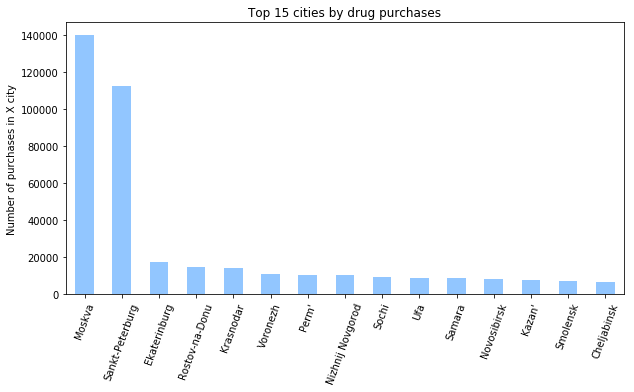

In [1014]:
## Plot 
# Top 15 cities by purchases

# Using pandas plotting (matplotlib sorts alphabetically and there's no quick flag to avoid that - annoying!)
locations_full.sort_values("purchases", ascending=False)[:15].plot(x="loc", y="purchases", 
                                                                   kind="bar", figsize=(10,5))
plt.xticks(rotation=70)
plt.ylabel("Number of purchases in X city")
plt.xlabel("")
plt.title("Top 15 cities by drug purchases")
plt.legend().remove()

plt.show()

In [1035]:
## Plot
# Plot geocoded points on map and size/color by purchase size

# Color scale
colscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
    [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(168, 168, 100)"]]

data = [go.Scattergeo(
        # Longitudes + latitudes of points
        lon = locations_full['lon'],
        lat = locations_full['lat'],
        # Text to display on hover
        text = locations_full['loc'] + " \nPurchases:" + locations_full['purchases'].astype(str),
        # Add markers
        mode = 'markers',
        marker = dict(
            # Marker size (log-transform purchases to avoid extreme sizes due to outliers)
            size = np.log(locations_full['purchases'])+2, reversescale = True,
            autocolorscale = False, 
            # Marker form
            symbol = 'circle', line = dict(width=1, color='rgba(102, 102, 102)'),
            # Color scale (based on purchases)
            colorscale = colscale,
            cmin = 0,
            color = locations_full['purchases'],
            cmax = locations_full['purchases'].max(),
            colorbar=dict(
                title="# Purchases in the city"
            )
        ))]

layout = dict(title = 'Drug purchase geography', 
        geo = dict(
            # Only available - asia/europe/usa/world/africa
            scope='europe',
            # Change projection
            projection=dict(type = "natural earth"),
            showland = True,
            # Land color
            landcolor = "rgb(250, 250, 250)",
            # Borders
            countrycolor = "rgb(0, 0, 0)",
            countrywidth = 0.5),
    )

# Plot
print("Notice that some points are in Czech Republic/France. These are likely cityname twins - geocoding errors")
fig = go.Figure(data=data, layout=layout )
py.iplot(fig, filename='d3-drugs')

Notice that some points are in Czech Republic/France. These are likely cityname twins - geocoding errors
